# Computational Drug Discovery

Performing Quantitative structure-activity relationship utilising the <a href="https://www.ebi.ac.uk/chembl/">ChEMBL</a> database.
Looking at a member of the sublcass of voltage gated sodium channels which is involved in nociceptic pathways (NaV1.7).  

##### References:  
###### Hameed S. Nav1.7 and Nav1.8: Role in the pathophysiology of pain. Mol Pain. 2019;15:1744806919858801. doi:10.1177/1744806919858801   
###### McDermott et al., 2019, Neuron 101, 905–919 March 6, 2019 https://doi.org/10.1016/j.neuron.2019.01.047  
###### Credit to <a href="https://github.com/dataprofessor">Data Professor</a> for the tutorial and functions  

In [89]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import pickle


In [5]:
from padelpy import padeldescriptor
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [33]:
import lazypredict
from lazypredict.Supervised import LazyRegressor
from scipy.stats import mannwhitneyu

In [93]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import joblib

## Searching for the target LA protein

In [4]:
target_la = new_client.target
target_la_query = target_la.search('nav1.7')
targets_la = pd.DataFrame.from_dict(target_la_query)
targets_la

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Nav1.7', 'xref_name': None, 'xre...",Homo sapiens,Sodium channel protein type IX alpha subunit,12.0,False,CHEMBL4296,"[{'accession': 'Q15858', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'O08562', 'xref_name': None, 'xre...",Rattus norvegicus,Sodium channel protein type IX alpha subunit,10.0,False,CHEMBL3312,"[{'accession': 'O08562', 'component_descriptio...",SINGLE PROTEIN,10116
2,[],Mus musculus,Sodium channel protein type 9 subunit alpha,10.0,False,CHEMBL3414411,"[{'accession': 'Q62205', 'component_descriptio...",SINGLE PROTEIN,10090
3,[],Homo sapiens,SCN9A/SCN1B,9.0,False,CHEMBL4523670,"[{'accession': 'Q15858', 'component_descriptio...",PROTEIN COMPLEX,9606
4,[],Homo sapiens,Sodium channel protein type 9 subunit alpha/be...,8.0,False,CHEMBL4630765,"[{'accession': 'Q15858', 'component_descriptio...",PROTEIN COMPLEX,9606
5,[],Mus musculus,Sodium channel protein type 9 subunit alpha/be...,8.0,False,CHEMBL4630766,"[{'accession': 'Q62205', 'component_descriptio...",PROTEIN COMPLEX,10090
6,[],Rattus norvegicus,Voltage-gated sodium channel,2.0,False,CHEMBL3988641,"[{'accession': 'O88457', 'component_descriptio...",PROTEIN FAMILY,10116
7,[],Homo sapiens,Sodium channel alpha subunit,1.0,False,CHEMBL2331043,"[{'accession': 'P35498', 'component_descriptio...",PROTEIN FAMILY,9606


## Select and retrieve bioactivity data for the human NaV1.7 channel protein

In [5]:
selected_target = targets_la.target_chembl_id[0]
selected_target

'CHEMBL4296'

In [7]:
activity = new_client.activity
target_activity = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [16]:
target_activity

[{'activity_comment': None, 'activity_id': 1431508, 'activity_properties': [], 'assay_chembl_id': 'CHEMBL874197', 'assay_description': 'In vitro inhibitory concentration against voltage-gated sodium channel Nav1.7 in voltage-ion-probe-reader (VIPR) assay', 'assay_type': 'F', 'assay_variant_accession': None, 'assay_variant_mutation': None, 'bao_endpoint': 'BAO_0000190', 'bao_format': 'BAO_0000019', 'bao_label': 'assay format', 'canonical_smiles': 'NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2ccccc2C(=O)NCc2ccc(-c3cccs3)s2)cc1', 'data_validity_comment': None, 'data_validity_description': None, 'document_chembl_id': 'CHEMBL1143509', 'document_journal': 'Bioorg. Med. Chem. Lett.', 'document_year': 2005, 'ligand_efficiency': None, 'molecule_chembl_id': 'CHEMBL360307', 'molecule_pref_name': None, 'parent_molecule_chembl_id': 'CHEMBL360307', 'pchembl_value': '5.66', 'potential_duplicate': False, 'qudt_units': 'http://www.openphacts.org/units/Nanomolar', 'record_id': 369507, 'relation': '=', 'src_id': 1,

In [24]:
with open("na17_activity.csv", "w") as f:
    w = csv.DictWriter(f, target_activity[0].keys())
    w.writeheader()
    for i in range(len(target_activity)):
        w.writerow(target_activity[i])

In [90]:
df = pd.read_csv("na17_activity.csv")
df.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,1431508,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.2
1,NaN,1431514,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.9
2,NaN,1431516,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,10.0


In [91]:
df.standard_type.unique()

array(['IC50'], dtype=object)

## Cleaning  
  
Drop any rows that have missing standard_values

In [7]:
df2 = df[df.standard_value.notna()]
df2.to_csv('na17_droppedna.csv', index=False)
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,1431508,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.20
1,NaN,1431514,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.90
2,NaN,1431516,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,10.00
3,NaN,1431517,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,5.30
4,NaN,1431518,[],CHEMBL874197,In vitro inhibitory concentration against volt...,F,NaN,NaN,BAO_0000190,BAO_0000019,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7557,NaN,20713817,[],CHEMBL4629734,Use-dependent inhibition of human Nav1.7 expre...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,52.10
7558,NaN,20713818,[],CHEMBL4629734,Use-dependent inhibition of human Nav1.7 expre...,B,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,71.00
7559,NaN,20713819,[],CHEMBL4629735,Inhibition of human Nav1.7 at resting state ex...,A,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,9.50
7560,NaN,20713820,[],CHEMBL4629735,Inhibition of human Nav1.7 at resting state ex...,A,NaN,NaN,BAO_0000190,BAO_0000219,...,Homo sapiens,Sodium channel protein type IX alpha subunit,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,2.28


In [92]:
df2 = pd.read_csv("na17_droppedna.csv")

## Data Pre-processing  
  
Labeling compounds as active, inactive or intermediate based on thresholds of IC50 units (nM):  
<1000 = active  
1000 <--> 10,000 = intermediate  
\>=10,000 = inactive  

In [93]:
bioactivity_class = []
for i in df2.standard_value:
    if float(i) >= 10000:
        bioactivity_class.append("inactive")
    elif float(i) <= 1000:
        bioactivity_class.append("active")
    else:
        bioactivity_class.append("intermediate")

In [94]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2[selection]
bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
df3 = pd.concat([df3, bioactivity_class], axis=1)
df3

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL360307,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2ccccc2C(=O)N...,2200.0,intermediate
1,CHEMBL183380,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2cccc(C(=O)NC...,2900.0,intermediate
2,CHEMBL359815,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc...,10000.0,inactive
3,CHEMBL179838,CN(Cc1ccc(-c2cccs2)s1)C(=O)[C@H]1CCC[C@@H]1C(=...,5300.0,intermediate
4,CHEMBL362660,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2cccs2...,1400.0,intermediate
...,...,...,...,...
7518,CHEMBL4637586,O=S(=O)(Nc1ncccn1)c1ccc2c(c1)OCC[C@@H]2c1ccc(C...,52.1,active
7519,CHEMBL4637997,Cn1nccc1-c1cc(C(F)(F)F)ccc1[C@H]1CCc2cc(S(=O)(...,71.0,active
7520,CHEMBL4632819,Cn1nccc1-c1cc(C(F)(F)F)ccc1[C@H]1CCOc2cc(S(=O)...,9500.0,intermediate
7521,CHEMBL4637917,O=S(=O)(Nc1ncccn1)c1ccc2c(c1)OCC[C@@H]2c1ccc(C...,2280.0,intermediate


In [95]:
df3.to_csv("na17_bioactivity_preprocessed.csv", index=False)
df3

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL360307,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2ccccc2C(=O)N...,2200.0,intermediate
1,CHEMBL183380,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2cccc(C(=O)NC...,2900.0,intermediate
2,CHEMBL359815,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc...,10000.0,inactive
3,CHEMBL179838,CN(Cc1ccc(-c2cccs2)s1)C(=O)[C@H]1CCC[C@@H]1C(=...,5300.0,intermediate
4,CHEMBL362660,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2cccs2...,1400.0,intermediate
...,...,...,...,...
7518,CHEMBL4637586,O=S(=O)(Nc1ncccn1)c1ccc2c(c1)OCC[C@@H]2c1ccc(C...,52.1,active
7519,CHEMBL4637997,Cn1nccc1-c1cc(C(F)(F)F)ccc1[C@H]1CCc2cc(S(=O)(...,71.0,active
7520,CHEMBL4632819,Cn1nccc1-c1cc(C(F)(F)F)ccc1[C@H]1CCOc2cc(S(=O)...,9500.0,intermediate
7521,CHEMBL4637917,O=S(=O)(Nc1ncccn1)c1ccc2c(c1)OCC[C@@H]2c1ccc(C...,2280.0,intermediate


# EDA

## Lipinski Descriptors  

To evaluate the drug-likeness of compounds, based on ADME (PK).  
- Molecular weight <500 Da
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10  
  

Utilising the molecular structure to generate the descriptors (via rdkit)

In [97]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [98]:
df_lipinski = lipinski(df3.canonical_smiles)

In [99]:
df_lipinski.to_csv("na17_lipinski.csv",index=False)
df_lipinski.head(4)

,MW,LogP,NumHDonors,NumHAcceptors
0,587.748,5.6510,3.0,6.0
1,587.748,5.6510,3.0,6.0
2,593.796,5.7009,3.0,6.0
3,593.796,5.4821,2.0,6.0


In [100]:
df_combined = pd.concat([df3,df_lipinski],axis=1)
df_combined.to_csv("na17_combined.csv", index=False)
df_combined.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL360307,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2ccccc2C(=O)N...,2200.0,intermediate,587.748,5.6510,3.0,6.0
1,CHEMBL183380,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2cccc(C(=O)NC...,2900.0,intermediate,587.748,5.6510,3.0,6.0
2,CHEMBL359815,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc...,10000.0,inactive,593.796,5.7009,3.0,6.0
3,CHEMBL179838,CN(Cc1ccc(-c2cccs2)s1)C(=O)[C@H]1CCC[C@@H]1C(=...,5300.0,intermediate,593.796,5.4821,2.0,6.0
4,CHEMBL362660,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2cccs2...,1400.0,intermediate,593.796,5.7009,3.0,6.0


In [101]:
df_combined = pd.read_csv("na17_combined.csv")
df_combined.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL360307,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2ccccc2C(=O)N...,2200.0,intermediate,587.748,5.6510,3.0,6.0
1,CHEMBL183380,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2cccc(C(=O)NC...,2900.0,intermediate,587.748,5.6510,3.0,6.0
2,CHEMBL359815,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc...,10000.0,inactive,593.796,5.7009,3.0,6.0
3,CHEMBL179838,CN(Cc1ccc(-c2cccs2)s1)C(=O)[C@H]1CCC[C@@H]1C(=...,5300.0,intermediate,593.796,5.4821,2.0,6.0
4,CHEMBL362660,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2cccs2...,1400.0,intermediate,593.796,5.7009,3.0,6.0


#### EDA & Further Cleaning

In [102]:
df_combined.describe()

,standard_value,MW,LogP,NumHDonors,NumHAcceptors
count,7.523000e+03,7523.000000,7523.000000,7523.000000,7523.000000
mean,1.032293e+04,619.908729,3.554709,3.678984,8.421374
std,6.456542e+05,727.911000,3.546701,11.115273,10.430116
min,1.000000e-02,179.263000,-21.955760,0.000000,1.000000
25%,5.710000e+01,424.892000,3.511490,1.000000,5.000000
50%,3.700000e+02,466.550000,4.225300,1.000000,6.000000
75%,2.100000e+03,517.563000,4.948080,2.000000,7.000000
max,5.600000e+07,4260.113000,10.734880,65.000000,62.000000


<AxesSubplot:xlabel='MW', ylabel='Count'>

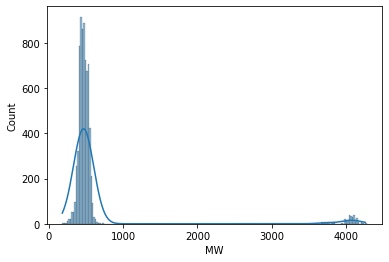

In [29]:
sns.histplot(data=df_combined,x="MW", binwidth=20, kde=True)

<AxesSubplot:xlabel='LogP', ylabel='Count'>

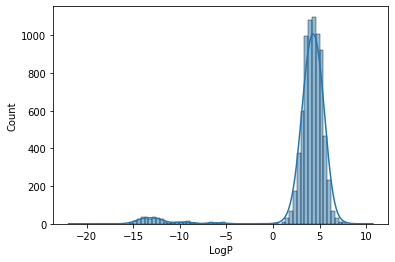

In [32]:
sns.histplot(data=df_combined,x="LogP",bins=80, kde=True)

<AxesSubplot:xlabel='LogP', ylabel='Count'>

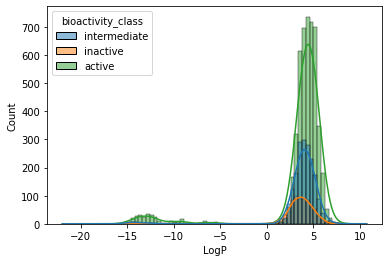

In [103]:
sns.histplot(data=df_combined,x="LogP",bins=80, kde=True, hue="bioactivity_class")

<AxesSubplot:xlabel='NumHDonors', ylabel='Count'>

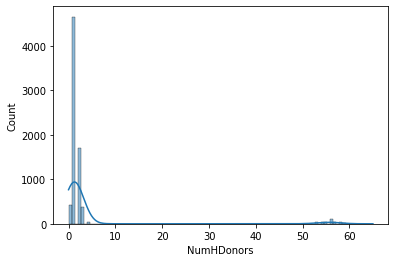

In [37]:
sns.histplot(data=df_combined,x="NumHDonors", bins=100, kde=True)

<AxesSubplot:xlabel='NumHAcceptors', ylabel='Count'>

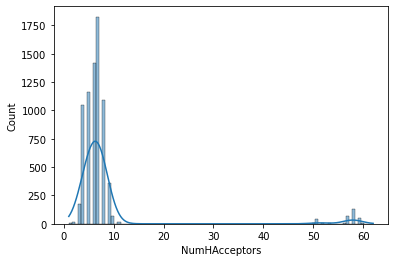

In [36]:
sns.histplot(data=df_combined,x="NumHAcceptors", bins=100, kde=True)

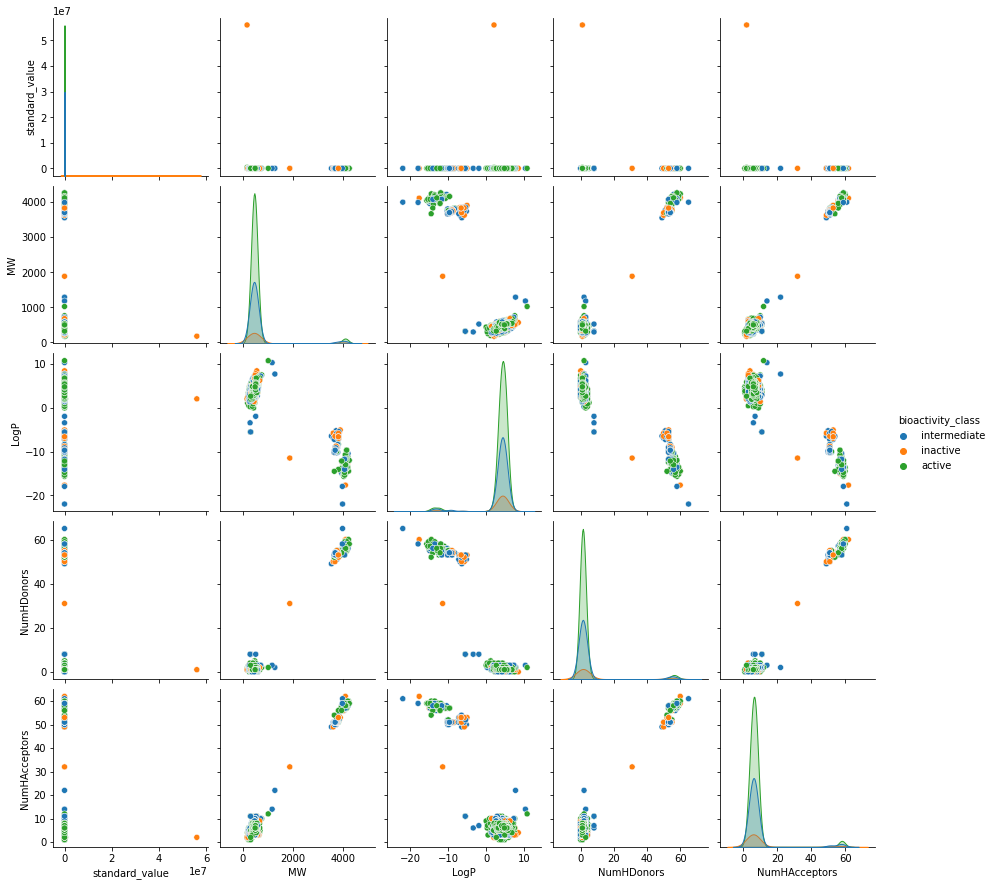

In [16]:
sns.pairplot(df_combined, hue="bioactivity_class")

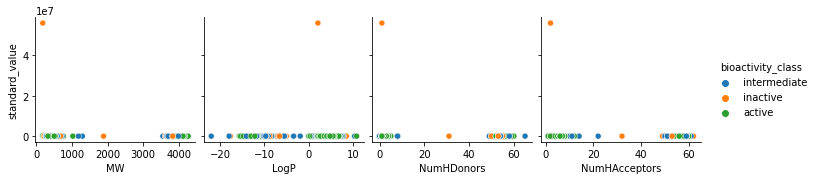

In [46]:
sns.pairplot(df_combined, x_vars=["MW","LogP","NumHDonors","NumHAcceptors"], y_vars="standard_value", hue="bioactivity_class")

### Remove outliers  

Based on Lipinski's rule and the distributions above, I will remove some outliers.
Generally as MW increases, absorption decreases, so I have chosen to filter out MWs > 1000.
For lipophilicity, whilst Lipinski's rule suggests <5 is optimal, there have been medications found with logP > 5 that have *some* eficacy, so I will filter between 0 and 10, and potentially revisit this later.
I will also apply Lipinski's rule to assist in filtering out further potential outliers for the number of hydrogen donors and acceptors i.e. between 0 and 5, and 0 and 10 respectively.

In [106]:
 df_combined_2 = df_combined[df_combined.MW.between(0,1000, inclusive=True) & df_combined.LogP.between(0,10, inclusive=True) & df_combined.NumHDonors.between(0,5, inclusive=True) & df_combined.NumHAcceptors.between(0,10, inclusive=True)]

In [107]:
df_combined_2.to_csv("na17_combined_filtered.csv", index=False)
df_combined_2 = pd.read_csv("na17_combined_filtered.csv")
df_combined_2.describe()

,standard_value,MW,LogP,NumHDonors,NumHAcceptors
count,7.174000e+03,7174.000000,7174.000000,7174.000000,7174.000000
mean,1.079545e+04,464.742896,4.281469,1.302760,6.206579
std,6.611709e+05,61.426904,0.975533,0.686896,1.566049
min,1.000000e-02,179.263000,0.233800,0.000000,1.000000
25%,6.062500e+01,423.419000,3.613400,1.000000,5.000000
50%,3.955000e+02,463.431000,4.284100,1.000000,6.000000
75%,2.260000e+03,509.946000,4.983600,2.000000,7.000000
max,5.600000e+07,761.852000,8.421500,5.000000,10.000000


<AxesSubplot:xlabel='MW', ylabel='Count'>

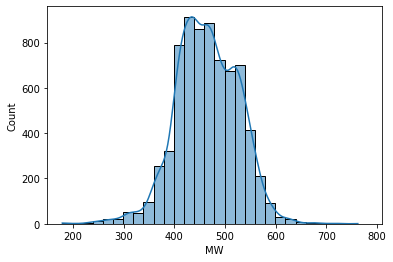

In [108]:
sns.histplot(data=df_combined_2,x="MW", binwidth=20, kde=True)

<AxesSubplot:xlabel='LogP', ylabel='Count'>

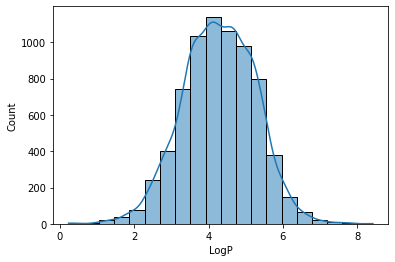

In [109]:
sns.histplot(data=df_combined_2,x="LogP", bins=20, kde=True)

<AxesSubplot:xlabel='NumHDonors', ylabel='Count'>

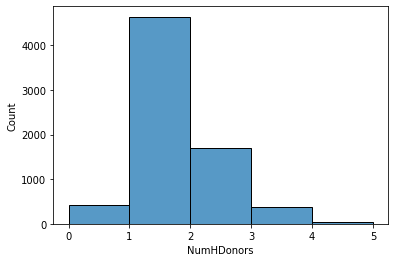

In [61]:
sns.histplot(data=df_combined_2,x="NumHDonors", bins=5)

<AxesSubplot:xlabel='NumHAcceptors', ylabel='Count'>

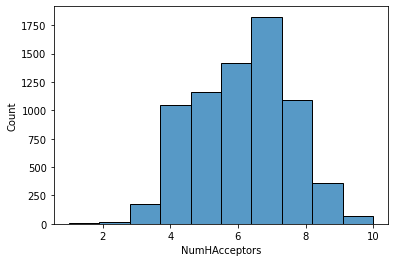

In [64]:
sns.histplot(data=df_combined_2,x="NumHAcceptors", bins=10)

### Normalise IC50 to pIC50  

Normalise IC50 column, then convert to pIC50 (negative log(10)), also convert the units from nM to M.
standard_values > 100,000,000 will be capped to avoid negative pIC50s.  
Credit: https://github.com/dataprofessor/code/blob/master/python/CDD_ML_Part_2_Exploratory_Data_Analysis.ipynb  

In [110]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    temp_df = input.drop('standard_value', 1)
    return temp_df

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    temp_df = input.drop('standard_value_norm', 1)
        
    return temp_df

In [111]:
df_norm = norm_value(df_combined_2)
df_norm.describe()

,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
count,7174.000000,7174.000000,7174.000000,7174.000000,7.174000e+03
mean,464.742896,4.281469,1.302760,6.206579,1.079545e+04
std,61.426904,0.975533,0.686896,1.566049,6.611709e+05
min,179.263000,0.233800,0.000000,1.000000,1.000000e-02
25%,423.419000,3.613400,1.000000,5.000000,6.062500e+01
50%,463.431000,4.284100,1.000000,6.000000,3.955000e+02
75%,509.946000,4.983600,2.000000,7.000000,2.260000e+03
max,761.852000,8.421500,5.000000,10.000000,5.600000e+07


In [112]:
df_pIC50 = pIC50(df_norm)
df_pIC50.describe()

,MW,LogP,NumHDonors,NumHAcceptors,pIC50
count,7174.000000,7174.000000,7174.000000,7174.000000,7174.000000
mean,464.742896,4.281469,1.302760,6.206579,6.449403
std,61.426904,0.975533,0.686896,1.566049,1.055650
min,179.263000,0.233800,0.000000,1.000000,1.251812
25%,423.419000,3.613400,1.000000,5.000000,5.645892
50%,463.431000,4.284100,1.000000,6.000000,6.402854
75%,509.946000,4.983600,2.000000,7.000000,7.217351
max,761.852000,8.421500,5.000000,10.000000,11.000000


In [6]:
df_pIC50.to_csv("na17_pIC50_3class.csv", index=False)
df_pIC50 = pd.read_csv("na17_pIC50_3class.csv")
df_pIC50.head(5)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL360307,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2ccccc2C(=O)N...,intermediate,587.748,5.6510,3.0,6.0,5.657577
1,CHEMBL183380,NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2cccc(C(=O)NC...,intermediate,587.748,5.6510,3.0,6.0,5.537602
2,CHEMBL359815,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc...,inactive,593.796,5.7009,3.0,6.0,5.000000
3,CHEMBL179838,CN(Cc1ccc(-c2cccs2)s1)C(=O)[C@H]1CCC[C@@H]1C(=...,intermediate,593.796,5.4821,2.0,6.0,5.275724
4,CHEMBL362660,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2cccs2...,intermediate,593.796,5.7009,3.0,6.0,5.853872


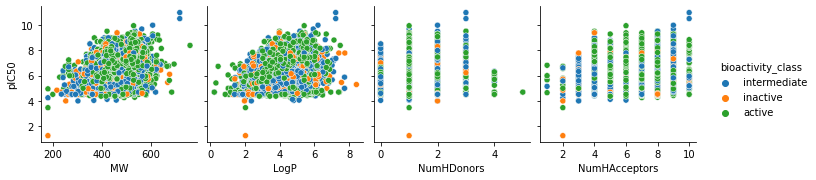

In [69]:
sns.pairplot(df_pIC50, x_vars=["MW","LogP","NumHDonors","NumHAcceptors"], y_vars="pIC50", hue="bioactivity_class")

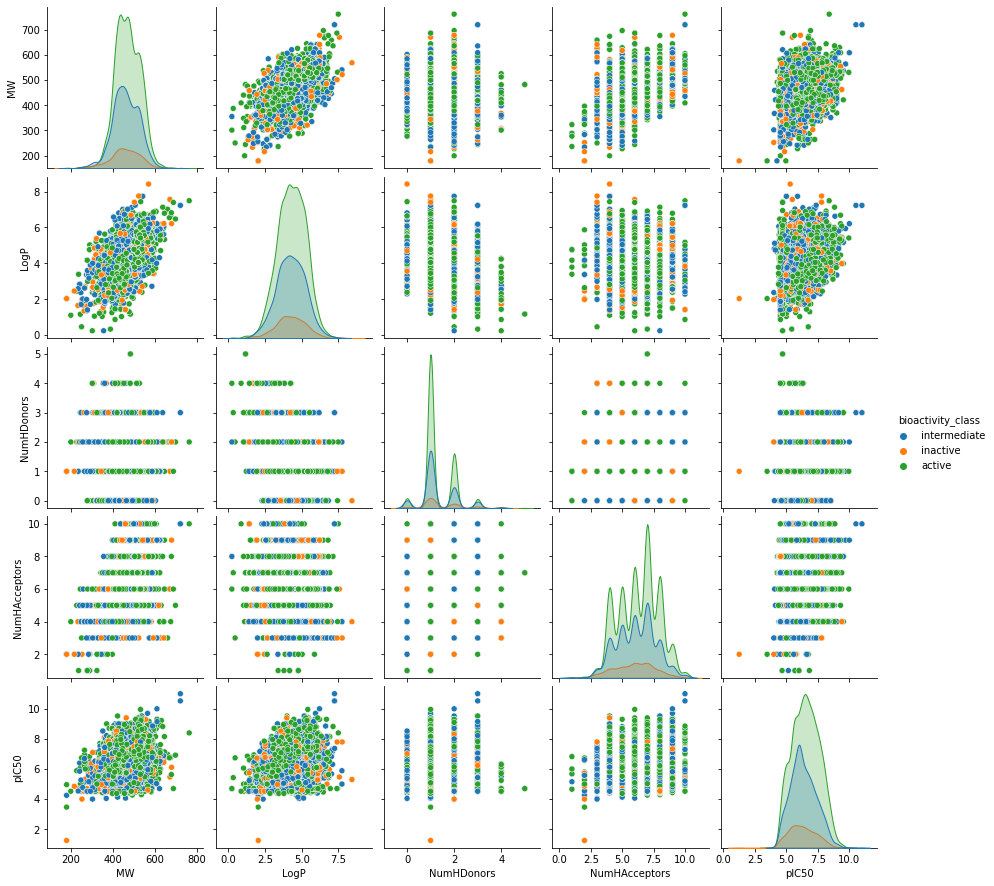

In [70]:
sns.pairplot(df_pIC50, hue="bioactivity_class")
# plt.savefig('df_pIC50.png')

##### Drop intermediate bioactivity class so we have active or inactive only

In [114]:
df_pIC50_2class = df_pIC50[df_pIC50.bioactivity_class != "intermediate"]
df_pIC50_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL359815,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc...,inactive,593.796,5.70090,3.0,6.0,5.000000
5,CHEMBL369537,CN(Cc1ccc(-c2ccccc2S(N)(=O)=O)cc1)C(=O)[C@H]1C...,active,593.796,5.48210,2.0,6.0,6.119186
6,CHEMBL362684,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)N(C)Cc1ccc(-c2cc...,inactive,607.823,6.04310,2.0,6.0,5.000000
7,CHEMBL181307,CN(Cc1ccc(-c2ccccc2S(N)(=O)=O)cc1)C(=O)[C@H]1C...,inactive,607.823,5.82430,1.0,6.0,5.000000
8,CHEMBL361961,O=C(NCc1ccc(-c2cccs2)s1)[C@H]1CCC[C@@H]1NCc1cc...,inactive,414.571,5.19040,2.0,4.0,5.000000
...,...,...,...,...,...,...,...,...
7166,CHEMBL4632819,Cn1nccc1-c1cc(C(F)(F)F)ccc1[C@H]1CCOc2cc(S(=O)...,active,515.517,4.61110,1.0,7.0,7.525784
7167,CHEMBL4637917,O=S(=O)(Nc1ncccn1)c1ccc2c(c1)OCC[C@@H]2c1ccc(C...,active,530.503,5.41170,1.0,6.0,7.464706
7168,CHEMBL4649472,Cc1ccc(-c2cc(C(F)(F)F)ccc2[C@H]2CCOc3cc(S(=O)(...,active,526.540,5.58102,1.0,6.0,6.966576
7169,CHEMBL4637586,O=S(=O)(Nc1ncccn1)c1ccc2c(c1)OCC[C@@H]2c1ccc(C...,active,520.533,4.04720,1.0,7.0,7.283162


In [115]:
df_pIC50_2class.to_csv("na17_pIC50_2class.csv", index=False)
df_pIC50_2class = pd.read_csv("na17_pIC50_2class.csv")
df_pIC50_2class.head(5)

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL359815,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc...,inactive,593.796,5.7009,3.0,6.0,5.000000
1,CHEMBL369537,CN(Cc1ccc(-c2ccccc2S(N)(=O)=O)cc1)C(=O)[C@H]1C...,active,593.796,5.4821,2.0,6.0,6.119186
2,CHEMBL362684,CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)N(C)Cc1ccc(-c2cc...,inactive,607.823,6.0431,2.0,6.0,5.000000
3,CHEMBL181307,CN(Cc1ccc(-c2ccccc2S(N)(=O)=O)cc1)C(=O)[C@H]1C...,inactive,607.823,5.8243,1.0,6.0,5.000000
4,CHEMBL361961,O=C(NCc1ccc(-c2cccs2)s1)[C@H]1CCC[C@@H]1NCc1cc...,inactive,414.571,5.1904,2.0,4.0,5.000000


In [136]:
df_pIC50_2class.describe()

,MW,LogP,NumHDonors,NumHAcceptors,pIC50
count,5353.000000,5353.000000,5353.000000,5353.000000,5353.000000
mean,470.523845,4.343848,1.321315,6.205866,6.752356
std,62.091347,0.974979,0.673730,1.586397,1.052602
min,179.263000,0.233800,0.000000,1.000000,1.251812
25%,428.448000,3.679000,1.000000,5.000000,6.218245
50%,470.498000,4.364880,1.000000,6.000000,6.793174
75%,518.354000,5.049600,2.000000,7.000000,7.481486
max,761.852000,7.753900,5.000000,10.000000,11.000000


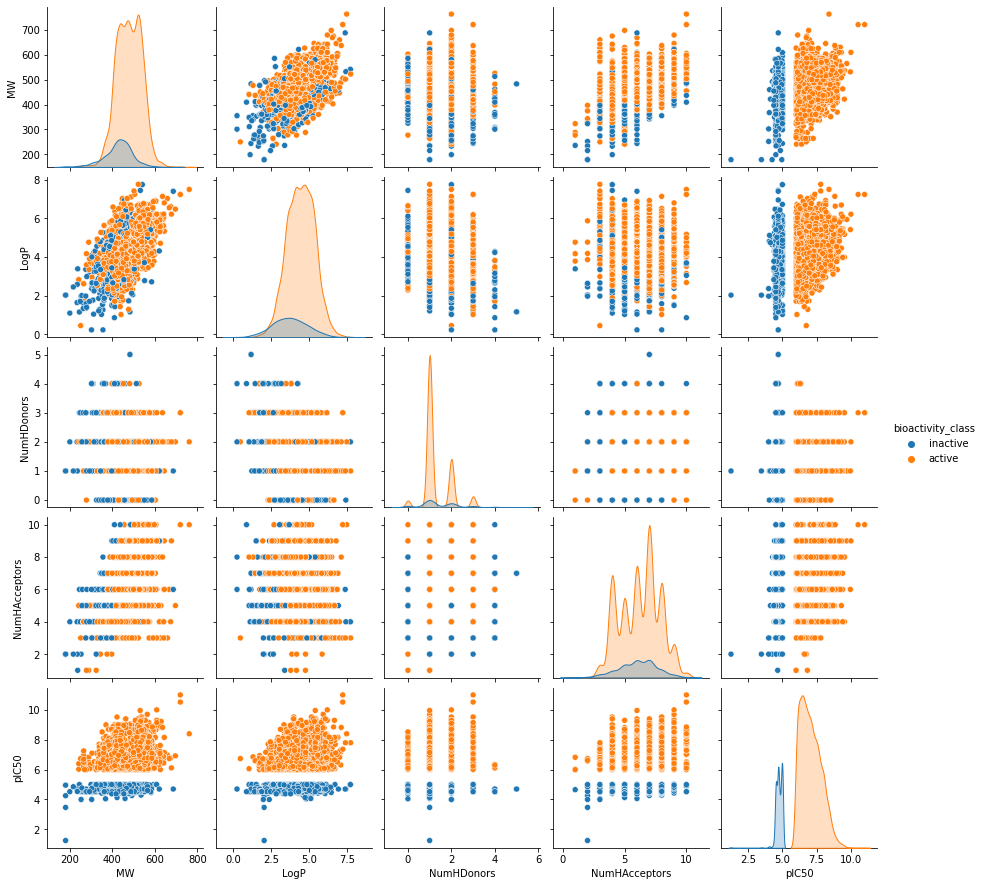

In [118]:
sns.pairplot(df_pIC50_2class, hue="bioactivity_class")
plt.savefig('df_pIC50_2class.png')

## Chemical Space Analysis with Lipinski Descriptors

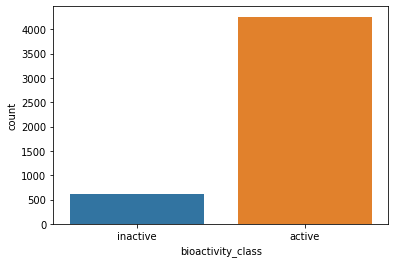

In [83]:
sns.countplot(data=df_pIC50_2class, x="bioactivity_class")
plt.savefig('count_bioactivity_class.png')

Compare the molecular weight and the lipophilicty to see if the active and inactive molecules span similar molecular spaces

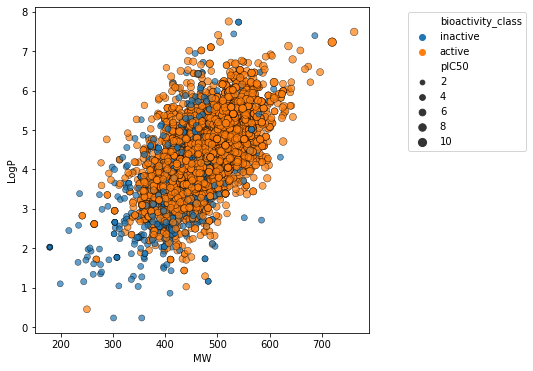

In [117]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='MW', y='LogP', data=df_pIC50_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)
plt.legend(bbox_to_anchor=(1.1, 1), loc=2)
plt.savefig('MW_vs_LogP.png')

pIC50 Box Plot

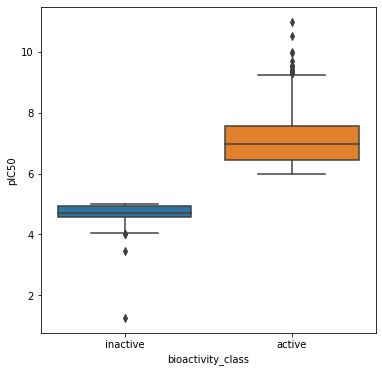

In [116]:
plt.figure(figsize=(6, 6))
sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_pIC50_2class)
plt.savefig('pIC50_boxplot.png')

## Statistical Testing  

To compare the difference between distributions for the activity classes, if any, and the statistical likelihood for this, we will use the Mann-Whitney U Test (we assume independent data samples).
The null hypothesis is that the distribution of pIC50 for active molecules and inactive molecules is the same. We will use a 95% CI to reject the null hypothesis and accept the alternative (that there is a difference in distribution - either way).

In [4]:
def mannwhitney(data, descriptor, alpha=0.05):

    selection = [descriptor, 'bioactivity_class']
    df = data[selection]
    active = df[df.bioactivity_class == 'active']
    active = active[descriptor]

    selection = [descriptor, 'bioactivity_class']
    df = data[selection]
    inactive = df[df.bioactivity_class == 'inactive']
    inactive = inactive[descriptor]

    # compare samples
    U1, p = mannwhitneyu(active, inactive)
    print('Statistics=%.3f, p=%.3f' % (U1, p))

    # interpret
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':U1,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename)

    return results

In [126]:
mannwhitney(df_pIC50_2class,'pIC50',0.05)

Statistics=3300462.000, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,3300462.0,0.0,0.05,Different distribution (reject H0)


MW Box Plot

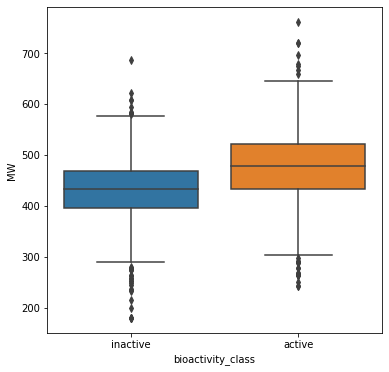

In [128]:
plt.figure(figsize=(6, 6))
sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_pIC50_2class)
plt.savefig('MW_boxplot.png')

In [129]:
mannwhitney(df_pIC50_2class,'MW',0.05)

Statistics=2352916.000, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2352916.0,6.696289e-75,0.05,Different distribution (reject H0)


LogP Box Plot

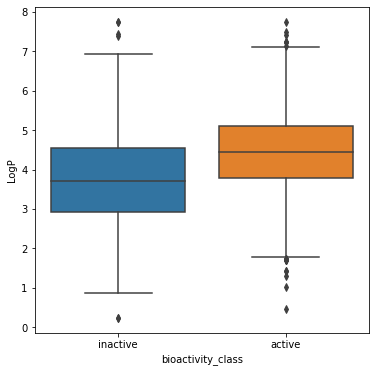

In [130]:
plt.figure(figsize=(6, 6))
sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_pIC50_2class)
plt.savefig('LogP_boxplot.png')

In [131]:
mannwhitney(df_pIC50_2class,'LogP',0.05)

Statistics=2248619.500, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2248619.5,8.043798e-55,0.05,Different distribution (reject H0)


HDonors Box Plot

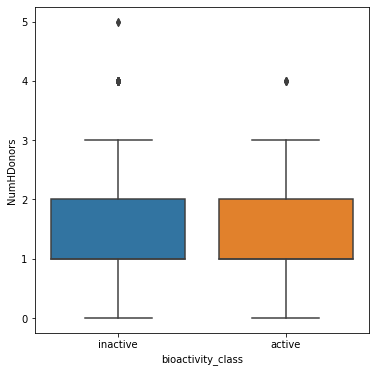

In [132]:
plt.figure(figsize=(6, 6))
sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_pIC50_2class)
plt.savefig('NumHDonors_boxplot.png')

In [133]:
mannwhitney(df_pIC50_2class,'NumHDonors',0.05)

Statistics=1480588.500, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1480588.5,1.008714e-07,0.05,Different distribution (reject H0)


HAcceptors Box Plot

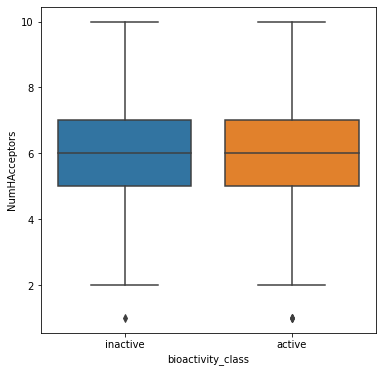

In [134]:
plt.figure(figsize=(6, 6))
sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_pIC50_2class)
plt.savefig('NumHAcceptors_boxplot.png')

In [135]:
mannwhitney(df_pIC50_2class,'NumHAcceptors',0.05)

Statistics=1748471.500, p=0.009


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1748471.5,0.009144,0.05,Different distribution (reject H0)


#### Interpretation  

pIC50s: the inactive and active molecules displayed statistically significant distributions (to be expected given we used a cutoff of <1000nM for active and >10,000nM for inactive, i.e. pIC50 >6 and <6 respectively).
  
For Lipinskis descriptors, all of the descriptors showed a statistically significant difference between active and inactive distributions, with an alpha of 0.05, and sample size, n of 5353:
- MW: U=2352916.000, p=0.000, two-tailed
- LogP: U=2248619.500, p=0.000, two-tailed
- HDonors: U=1480588.500, p=0.000, two-tailed
- HAcceptors: U=1748471.500, p=0.009, two-tailed

### Generate Chemical Fingerprint Descriptors  

Remove NaCl and small organic salts (remove impurities) and compute Pubchem fingerprints for the molecules

In [157]:
selection = ["canonical_smiles","molecule_chembl_id"]
df_pIC50_selection = df_pIC50[selection]
df_pIC50_selection.to_csv('molecules.smi', sep='\t', index=False, header=False)

In [158]:
! head -5 molecules.smi

NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2ccccc2C(=O)NCc2ccc(-c3cccs3)s2)cc1	CHEMBL360307
NS(=O)(=O)c1ccccc1-c1ccc(CNC(=O)c2cccc(C(=O)NCc3ccc(-c4cccs4)s3)c2)cc1	CHEMBL183380
CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc2S(N)(=O)=O)cc1)c1ccc(-c2cccs2)s1	CHEMBL359815
CN(Cc1ccc(-c2cccs2)s1)C(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2ccccc2S(N)(=O)=O)cc1	CHEMBL179838
CC(NC(=O)[C@H]1CCC[C@@H]1C(=O)NCc1ccc(-c2cccs2)s1)c1ccc(-c2ccccc2S(N)(=O)=O)cc1	CHEMBL362660


In [159]:
! wc -l molecules.smi

7174 molecules.smi


In [160]:
padeldescriptor(mol_dir='molecules.smi', d_file='descriptors.csv', removesalt=True, standardizenitro=True, fingerprints=True)

## Prep Data Matrices

#### X Data Matrix  
X = molecular fingerprints

In [4]:
df_X = pd.read_csv("descriptors.csv")
df_X = df_X.drop(columns=["Name"])
df_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7170,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7171,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7172,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Y Data Matrix 

y = pIC50

In [7]:
df_Y = df_pIC50["pIC50"]
df_Y

0       5.657577
1       5.537602
2       5.000000
3       5.275724
4       5.853872
          ...   
7169    7.283162
7170    7.148742
7171    5.022276
7172    5.642065
7173    5.091515
Name: pIC50, Length: 7174, dtype: float64

In [8]:
df_XY = pd.concat([df_X,df_Y], axis=1)
df_XY

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.657577
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.537602
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.275724
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.853872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.283162
7170,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.148742
7171,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.022276
7172,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.642065


In [165]:
df_XY.to_csv("na17_3class_pubchem_fp.csv", index=False)
df_XY = pd.read_csv("na17_3class_pubchem_fp.csv")
df_XY

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.657577
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.537602
2,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.275724
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.853872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.283162
7170,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.148742
7171,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.022276
7172,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.642065


## Building Classification Models  

Start by removing low variance features

In [77]:
df_XY = pd.read_csv("na17_3class_pubchem_fp.csv")

In [78]:
X = df_XY.drop('pIC50',axis=1)
X.shape

(7174, 881)

In [79]:
Y = df_XY.pIC50
Y.shape

(7174,)

Remove low variance features in 80% of our samples, as they won't contribute much to the predictive power of the model.  
As we have boolean features in our molecular descriptors, we can use the Bernoulli random variable variance formula:  
Var[X] = p * (1 - p)  
where p is the probability of X, P(X)

In [11]:

selection = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))    
X = selection.fit_transform(X)
X.shape

(7174, 161)

### Split into Testing and Training Datasets (20/80)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [50]:
X_train.shape, Y_train.shape

((5739, 161), (5739,))

In [49]:
X_test.shape, Y_test.shape

((1435, 161), (1435,))

## Random Forest Regression Model

In [15]:
np.random.seed(5)
model1 = RandomForestRegressor(n_estimators=100, max_depth=10)
model1.fit(X_train, Y_train)
model1_r2 = model1.score(X_train,Y_train)
model1_r2
# Initial attempt at hyperparameter tuning
# r2_array = []
# for i in range(1,15)
#     model = RandomForestRegressor(n_estimators=100, max_depth=i)
#     model.fit(X_train, Y_train)
#     r2 = model.score(X_test, Y_test)
#     r2_array.append(str(i) + ": " + str(r2))
# r2_array

0.6184696554901434

In [16]:
Y_train_pred = model1.predict(X_train)
Y_test_pred = model1.predict(X_test)

(0.0, 10.0)

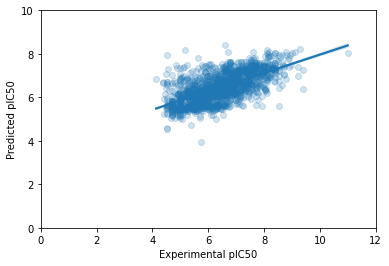

In [37]:
ax = sns.regplot(x=Y_test, y=Y_test_pred, scatter_kws={'alpha':0.2})
ax.set_xlabel('Experimental pIC50')
ax.set_ylabel('Predicted pIC50')
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)

### Comparing different Regressors

In [38]:
lr = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = lr.fit(X_train, X_train, Y_train, Y_train)

100%|██████████| 56/56 [00:00<00:00, 292869.11it/s]


In [43]:
predictions_train

100%|██████████| 56/56 [00:00<00:00, 634813.58it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.79,0.80,0.48,6.60
ExtraTreeRegressor,0.79,0.80,0.48,0.12
DecisionTreeRegressor,0.79,0.80,0.48,0.10
RadiusNeighborsRegressor,0.79,0.80,0.48,5.20
GaussianProcessRegressor,0.79,0.80,0.48,7.93
RandomForestRegressor,0.75,0.75,0.52,4.69
BaggingRegressor,0.72,0.73,0.55,0.53
XGBRegressor,0.71,0.72,0.56,0.71
MLPRegressor,0.66,0.67,0.61,17.31


In [51]:
lr2 = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_test,predictions_test = lr2.fit(X_train, X_test, Y_train, Y_test)
predictions_test


100%|██████████| 56/56 [04:20<00:00,  4.65s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.35,0.43,0.79,1.56
LGBMRegressor,0.35,0.43,0.79,0.19
NuSVR,0.35,0.42,0.80,2.78
SVR,0.33,0.41,0.80,3.45
GradientBoostingRegressor,0.32,0.40,0.81,1.82
XGBRegressor,0.28,0.36,0.83,0.67
RandomForestRegressor,0.27,0.35,0.84,4.55
KNeighborsRegressor,0.27,0.35,0.84,1.32
RidgeCV,0.25,0.34,0.85,0.11


[(0.0, 1.0)]

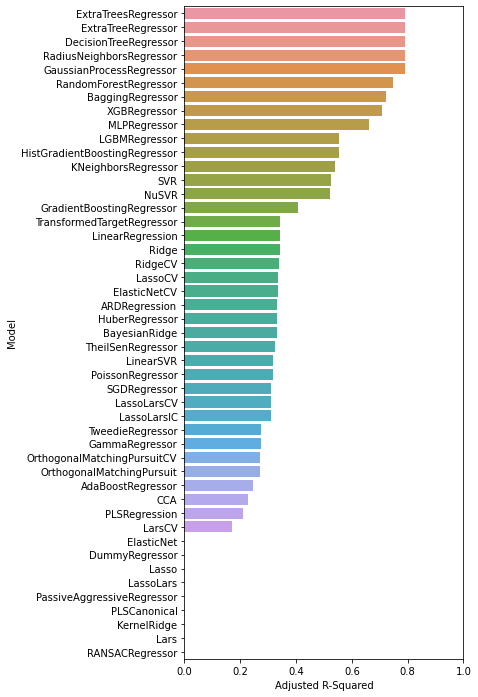

In [53]:
plt.figure(figsize=(5, 12))
ax = sns.barplot(y=predictions_train.index, x="Adjusted R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

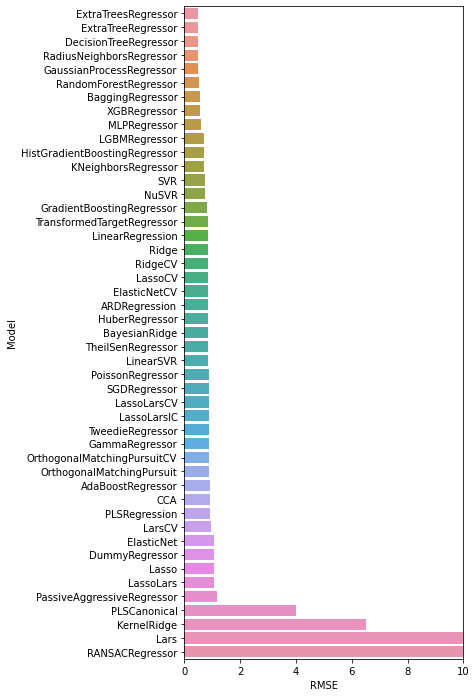

In [48]:
plt.figure(figsize=(5, 12))
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

### Random Hyperparameter Grid  

Looks like whilst the Random Forest regressor performed reasonably well on the training data set, it did not perform so well on the test dataset, suggesting overfitting.  
I will attempt to employ cross validation utilising the K-Fold CV process, iteratively, using Random Search Cross Validation from Scikit-Learn.  

Credit: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [57]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 20)]
max_features = ['auto', 'sqrt'] #Number of features allowed to make the best split while building the tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 10)]
min_samples_split = [15, 30, 60] # Minimum number of samples required to split a node
min_samples_leaf = [1, 5, 10] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 16, 28, 40, 51, 63, 75, 86, 98, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 5, 10],
 'min_samples_split': [15, 30, 60],
 'n_estimators': [50,
                  152,
                  255,
                  357,
                  460,
                  563,
                  665,
                  768,
                  871,
                  973,
                  1076,
                  1178,
                  1281,
                  1384,
                  1486,
                  1589,
                  1692,
                  1794,
                  1897,
                  2000]}


Create a bse model for tuning, start with a random search with 3-fold CV.

In [58]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=98, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=1897; total time=   8.7s
[CV] END bootstrap=True, max_depth=98, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=1897; total time=   9.4s
[CV] END bootstrap=True, max_depth=98, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=1897; total time=   9.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=768; total time=   3.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=768; total time=   3.7s
[CV] END bootstrap=True, max_depth=86, max_features=auto, min_samples_leaf=1, min_samples_split=30, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 16, 28, 40, 51, 63, 75,
                                                      86, 98, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [15, 30, 60],
                                        'n_estimators': [50, 152, 255, 357, 460,
                                                         563, 665, 768, 871,
                                                         973, 1076, 1178, 1281,
                                                         1384, 1486, 1589, 1692,
                                                         1794, 1897, 2000]},
                   random_state=42, verbose=2)

In [59]:
rf_random.best_params_

{'n_estimators': 1486,
 'min_samples_split': 15,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [60]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [74]:
#Based on my previous attempts at tuning
base_model = RandomForestRegressor(n_estimators = 100, max_depth=10, random_state = 5)
base_model.fit(X_train, Y_train)
base_accuracy = evaluate(base_model, X_test, Y_test)

Model Performance
Average Error: 0.6189 degrees.
Accuracy = 89.95%.


In [62]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, Y_test)

Model Performance
Average Error: 0.6178 degrees.
Accuracy = 89.97%.


In [63]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.03%.


Attempt GridSearch with CV, based on parameters from the best random search

In [67]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [100, 110, 120, 130],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4, 5,6],
    'min_samples_split': [12, 15, 18],
    'n_estimators': [1200, 1300, 1400, 1500]
}

In [68]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [69]:
grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1200; total time=   7.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1200; total time=   8.3s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1200; total time=   8.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1300; total time=   9.1s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1400; total time=   9.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1300; total time=   9.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [100, 110, 120, 130],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [12, 15, 18],
                         'n_estimators': [1200, 1300, 1400, 1500]},
             verbose=2)

In [70]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 1500}

In [75]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, Y_test)

Model Performance
Average Error: 0.6154 degrees.
Accuracy = 90.02%.


In [76]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.08%.


In [86]:
Y_pred_train_grid = best_grid.predict(X_train)
Y_pred_test_grid = best_grid.predict(X_test)

(0.0, 10.0)

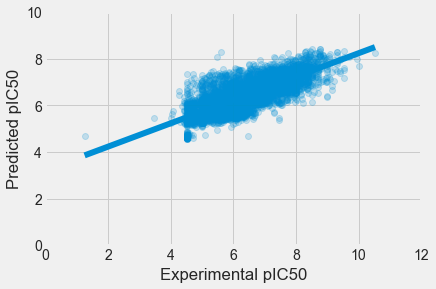

In [87]:
ax = sns.regplot(x=Y_train, y=Y_pred_train_grid, scatter_kws={'alpha':0.2})
ax.set_xlabel('Experimental pIC50')
ax.set_ylabel('Predicted pIC50')
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)

(0.0, 10.0)

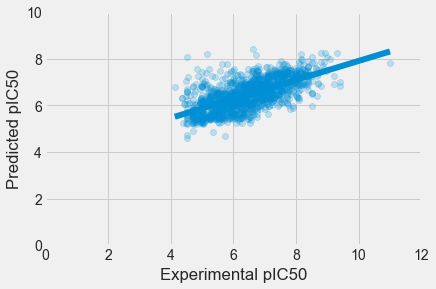

In [88]:
ax = sns.regplot(x=Y_test, y=Y_pred_test_grid, scatter_kws={'alpha':0.2})
ax.set_xlabel('Experimental pIC50')
ax.set_ylabel('Predicted pIC50')
ax.set_xlim(0, 12)
ax.set_ylim(0, 10)